## Age and Gender detector

In many culture, it is rude to ask the age or gender of some stranger we meet and many of us will just try to guess how old is that stanger. I think a trained machine with huge dataset can do the guess better than human brains.

In [34]:
import cv2
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

## Model specification
The model I choose to use is Convolutional Neural Network model, the input of the model is image array with size (48,48,3), the output of my model is a 2d-array consits of ages and genders. Since there are two kinds of output, my model also has two loss functions, one is Binary Cross Entropy for sex, the other one is Mean Absolute Error for age.

In [26]:
# CNN model

def Convolution(input_tensor,filters):
    
    x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1),kernel_regularizer=l2(0.001))(input_tensor)
    x = Dropout(0.1)(x)
    x= Activation('relu')(x)

    return x
def model(input_shape, num_filters=[64,64,128,256], lr=0.001, dropout=0.1):
    inputs = Input((input_shape))
  
    conv_1= Convolution(inputs,num_filters[0])
    maxp_1 = MaxPooling2D(pool_size = (2,2)) (conv_1)
    conv_2 = Convolution(maxp_1,num_filters[1])
    maxp_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)
    conv_3 = Convolution(maxp_2,num_filters[2])
    maxp_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)
    conv_4 = Convolution(maxp_3,num_filters[3])
    maxp_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)
    flatten= Flatten() (maxp_4)
    dense_1= Dense(64,activation='relu')(flatten)
    dense_2= Dense(64,activation='relu')(flatten)
    drop_1=Dropout(dropout)(dense_1)
    drop_2=Dropout(dropout)(dense_2)
    output_1= Dense(1,activation="sigmoid",name='sex')(drop_1)
    output_2= Dense(1,activation="relu",name='age')(drop_2)
    model = Model(inputs=[inputs], outputs=[output_1,output_2])
    opt = Adam(learning_rate=lr)
    model.compile(loss=["binary_crossentropy","mae"], optimizer=opt, 
                  metrics=["accuracy"])
    
    return model

## Specify features and pre-processing 
My dataset consists images of human face and labels of human gender and age. The dataset is processed so I only need to resize images to 48x48 and normalized the image, then convert images and labels to numpy array.

In [6]:
path="archive/UTKFace"
files=os.listdir(path)
ages=[]
genders=[]
images=[]

for fle in files:
    age=int(fle.split('_')[0])
    gender=int(fle.split('_')[1])
    total=path+'/'+fle
    image=cv2.imread(total)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image= cv2.resize(image,(48,48))

    images.append(image)
    ages.append(age)
    genders.append(gender)

# convert data into numpy array
# normalize images so /255
images=np.array(images)/255
genders=np.array(genders)
ages=np.array(ages)

In [ ]:
plt.figure(1, figsize=(8,8))
for i in range(0,5,1):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i,:,:])
    if genders[i]==1 :
        gender_temp = 'female'
    else:
        gender_temp = 'male'
    plt.title(f'age: {ages[i]}\n{gender_temp}')
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

In [16]:
# store ages and genders into one array labels
labels=[]
for i in range(0, len(ages),1):
    label=[]
    label.append([ages[i]])
    label.append([genders[i]])
    labels.append(label)

labels=np.array(labels)

## Specify data split strategy
The total dataset contained 23,708 examples. The data was
randomly permuted, then divided into Two subsets: 60% training, 20%
validation, and 20% test. Models were trained on the training set, while the
validation set was used for early stopping, hyperparameter optimization. The test set was used to evaluate the final model.

In [29]:
X_train, X_test, y_train, y_test= train_test_split(images, labels, test_size=0.2, shuffle=True)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.25)

# shape of y is (numberOfData, 2, 1)
#     then change it to (2, numberOfData, 1)
y_train=[y_train[:,1],y_train[:,0]]
y_test=[y_test[:,1],y_test[:,0]]
y_val=[y_val[:,1],y_val[:,0]]

## Specify the hyperparameter search space
For the Convolutional Neural Network classifier we tried different numbers
of filters of Convolution , different learning rateand, and different drop out rate. We have four convolution layers so we tried 3 different combination of number of filters for each layer, {[64, 64, 64, 64], [64, 64, 128, 256], [64, 128, 128, 256]}. We tried the 0.01 and 0.001 for learning rate and 0.1, 0.25, 0.5 for drop out rate.

In [22]:
nums_filters = [[64, 64, 64, 64], [64, 64, 128, 256], [64, 128, 128, 256]]
lrs = [0.01, 0.001]
dors = [0.1, 0.25, 0.5]

After trying all combinations of hyperparameters in the search
space, the model with the highest accuracy on the validation set was selected. The optimal numbers of filters is [64, 128, 128, 512], optimal learning rate is 0.001, optimal dropout rate is 0.1. Using these optimal hyperparameters my model get validation set accuracy is 0.85.

In [44]:
max_accuracy = 0
best_prameters = {"lr": 0, "filters": [], "dropout": 0}
for lr in lrs:
    for dropout in dors:
        for filters in nums_filters:
            tuning_model=model((48,48,3), filters, lr, dropout)
            history = tuning_model.fit(X_train,y_train,batch_size=64,validation_data=(X_val, y_val),epochs=10,verbose=0)
            sex_accuracy = history.history['val_sex_accuracy'][-1]
            if sex_accuracy > max_accuracy:
                max_accuracy = sex_accuracy
                best_prameters["lr"] = lr
                best_prameters["filters"] = filters
                best_prameters["dropout"] = dropout
print("optimal learning rate is ", best_prameters["lr"])
print("optimal numbers of filters is ", best_prameters["filters"])
print("optimal dropout rate is ", best_prameters["dropout"])
print("the optimal sex_accuracy for validation set is ", max_accuracy)

optimal learning rate is  0.001
optimal numbers of filters is  [64, 128, 128, 256]
optimal dropout rate is  0.1
the optimal sex_accuracy for validation set is  0.8481653332710266


In [40]:
my_model=model((48,48,3), [64,128,128,256],0.001,0.1)  # call the model with input size of image size
Early_stop=tf.keras.callbacks.EarlyStopping(patience=25, monitor='val_loss',restore_best_weights=True),
callback_list=[Early_stop]
History=my_model.fit(X_train,y_train,batch_size=64,validation_data=(X_val, y_val),epochs=10,callbacks=[callback_list])

Epoch 1/10
223/223 [==============================] - 53s 233ms/step - loss: 18.5143 - sex_loss: 0.7016 - age_loss: 17.5856 - sex_accuracy: 0.5522 - age_accuracy: 0.0436 - val_loss: 16.7367 - val_sex_loss: 0.6745 - val_age_loss: 15.9033 - val_sex_accuracy: 0.5261 - val_age_accuracy: 0.0496
Epoch 2/10
223/223 [==============================] - 53s 237ms/step - loss: 15.4355 - sex_loss: 0.6489 - age_loss: 14.6237 - sex_accuracy: 0.6204 - age_accuracy: 0.0476 - val_loss: 17.0983 - val_sex_loss: 0.5745 - val_age_loss: 16.3275 - val_sex_accuracy: 0.7423 - val_age_accuracy: 0.0493
Epoch 3/10
223/223 [==============================] - 52s 234ms/step - loss: 12.0605 - sex_loss: 0.5681 - age_loss: 11.2812 - sex_accuracy: 0.7134 - age_accuracy: 0.0456 - val_loss: 12.0716 - val_sex_loss: 0.5142 - val_age_loss: 11.3139 - val_sex_accuracy: 0.7619 - val_age_accuracy: 0.0458
Epoch 4/10
223/223 [==============================] - 53s 237ms/step - loss: 10.9366 - sex_loss: 0.5157 - age_loss: 10.1700 - s

## Evaluate model on clean test set 

In [47]:
predict = my_model.predict(X_test)
predict = np.round(predict)

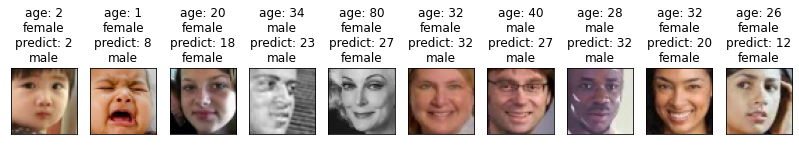

In [49]:
plt.figure(1, figsize=(14,6))
for i in range(0,10,1):
    plt.subplot(1,10,i+1)
    plt.imshow(X_test[i,:,:])
    if y_test[0][i]==1 :
        gender_temp = 'female'
    else:
        gender_temp = 'male'

    if predict[0][i]==1 :
        gender_pred = 'female'
    else:
        gender_pred = 'male'
    plt.title(f'age: {y_test[1][i][0]}\n{gender_temp}\npredict: {int(predict[1][i][0])}\n{gender_pred}')
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

### For gender prediction:

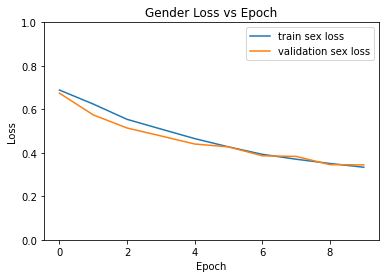

In [55]:
plt.plot(History.history['sex_loss'], label='train sex loss')
plt.plot(History.history['val_sex_loss'], label = 'validation sex loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Gender Loss vs Epoch')
plt.ylim([0, 1])
plt.legend(loc='upper right')

#### Our model got result for gender is 0.85 test set accuracy.

In [57]:
print('test gender accuracy = ', History.history['val_sex_accuracy'][-1])

test gender accuracy =  0.8481653332710266


### For age prediction:
Since we have 101 classes (0-100) for age, we think it is fair to let machine have accepted error range within +/- 10, which means if the predict age = true age +/- 10, then we treat it as right. And our model get 0.54 test accuracy for age prediction.

In [68]:
# calculate age accuracy function
def cal_accuracy(pred_labels, true_labels):
    accuracy = np.count_nonzero(np.abs(pred_labels-true_labels) <= 10)/len(true_labels)
    return accuracy
print("test age accuracy = ", cal_accuracy(predict[1], y_test[1]))

test age accuracy =  0.5383804301982286


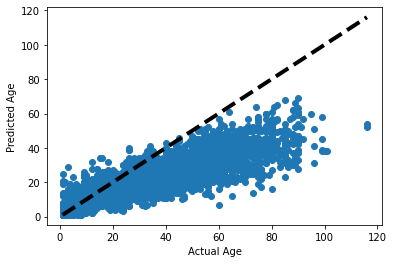

In [69]:
fig, ax = plt.subplots()
ax.scatter(y_test[1], predict[1])
ax.plot([y_test[1].min(),y_test[1].max()], [y_test[1].min(), y_test[1].max()], 'k--', lw=4)
ax.set_xlabel('Actual Age')
ax.set_ylabel('Predicted Age')
plt.show()

From the plot above, we can see that our model did a great job on people under 60 which is because the number of 60+ image in training set is not enough, to improve this model, we can add more data to training set.

In [85]:
print("number of people under 60 in training set: ", np.sum(y_train[1] < 60))
print("number of people over 60: in training set:", np.sum(y_train[1] >= 60))

print("number of people under 60 in val set: ", np.sum(y_val[1] < 60))
print("number of people over 60 in val set: ", np.sum(y_val[1] >= 60))

print("number of people under 60 in test set: ", np.sum(y_test[1] < 60))
print("number of people over 60 in test set: ", np.sum(y_test[1] >= 60))

number of people under 60 in training set:  12630
number of people over 60: in training set: 1594
number of people under 60 in val set:  4207
number of people over 60 in val set:  535
number of people under 60 in test set:  4181
number of people over 60 in test set:  561


### Explain any differences in the train/test datasets 

The test set is from a later time than the training set, so data
drift could harm model performance.